# Objective
Our objective for this exercise is quite modest. We will use Bayesian optimization for hyperparameter tuning of XGBoost and neural network models. We will add noise to the graph of $y = \sin(2\pi x)$. Then we write the average sum of square error from cross-validation as a function $f$ of our hyperparameters $\theta$. That is, we will consider 
$$
f: \theta \mapsto \text{average sum of square error given }\theta.
$$
We will estimate $f$ using a Gaussian process $\hat{f}$. Minimize this estimate. Evaluate $f$ at the value of $\theta$ which maximizes the probability of improvement and recalculate $\hat{f}$ based on the result. That is, we will recaluate $\hat{f}$ based on the random variable $f(\theta^*)$, where
$$
\displaystyle\theta^* = \max_\theta \mathbb{E}[u(\theta)]\quad\text{and}\quad u(\theta) = \begin{cases} 1, & \hat{f}(\theta) \leq \min_\eta\hat{f}(\eta)\\ 0, & \text{otherwise.}\end{cases}
$$
We will repeat the process until the process converges or we reach the maximum number of iterations (50). 

This optimization process is less computationally intensive but less accurate compared to grid search or random search. It is most utility when evaluation of $f$ is 'expensive' in some sense of the word. 

# Packages

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.neural_network as nn
from sklearn.model_selection import cross_val_score
import GPyOpt
import time

# Generating the data
As mentioned previously, we will consider the graph of $y = \sin(2\pi x)$ and add noise to the $y$-values. In particular, we will map
$$
y_i \mapsto y_i + \epsilon_i
$$
where $\epsilon_i\sim{\mathcal{N}(0, 0.1^2)}$ and $\epsilon_i$ is independent from $\epsilon_j$ for $i\neq j$. We will generate $N = 10^5$ values because neural networks require a large amound of data to be effictive prediction models.

In [166]:
# Record start time
start_time = time.time()

# Set the random seed so results are reproducable 
np.random.seed(0)

# Number of data points; large so neural network is effective
N = 10**5

# Create data
x = np.linspace(0, 1, N)
y = np.sin(2 * np.pi * x)

# Add noise to y
y_noisy = y + np.random.normal(loc = 0, scale = 0.1, size = N)

# Reshape x
x = x.reshape((N, 1))


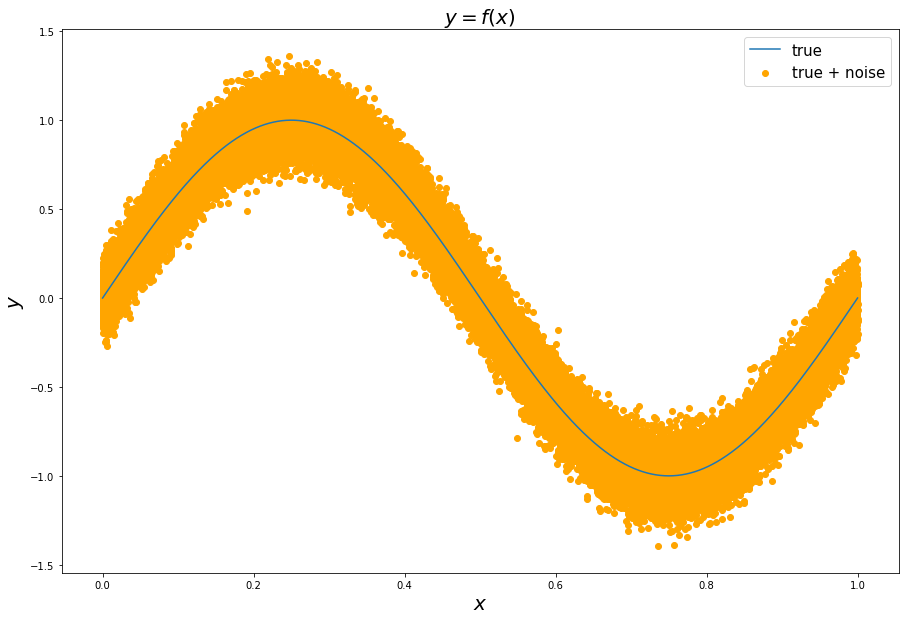

In [167]:
# Plot the graph and the graph with noisy y-values
fig, ax = plt.subplots(1, 1, figsize = (15, 10))

ax.set_title(r'$ y = f(x)$', fontsize = 20)
ax.set_xlabel(r'$x$', fontsize = 20)
ax.set_ylabel(r'$y$', fontsize = 20)

ax.plot(x, y, label = 'true')
ax.scatter(x_train, y_train, label = 'true + noise', color = 'orange')
ax.legend(fontsize = 15)

plt.show()

# Bayesian Optization
The code below creates a data frame and function to help us monitor our results.

In [168]:
# Create data frame to hold information about model improvement due to hyperparameters
results = pd.DataFrame(np.zeros((2, 4)), index = ['xgb', 'nn'], columns = ['baseline', 'avg_mse', 'gain', 'true_mse'])

# Define function to get MSE
get_mse = lambda y_pred: np.mean((y - y_pred)**2)

We will use Gaussian processes to minimize the object functions obj_xgb and obj_nn. Notice that they are both functions of the hyperparameters of their corresponding models, and their outputs are the average sum of square error from cross validation.

Of particular interest is the activation function of the neural network is not a parameter of obj_nn. We do not know of a way to use Bayesian optimization for categorical variables. The default activation function is relu.

In [169]:
# Define objective function for XGBoost
def obj_xgb(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        xgb.XGBRegressor(
            learning_rate=parameters[0],
            gamma = parameters[1],
            max_depth = int(parameters[2]),
             n_estimators =int(parameters[3])),
        x_train, y_train, scoring = 'neg_mean_squared_error').mean()
    score = np.array(score)
    return score

# Define objective function for neural net
def obj_nn(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        nn.MLPRegressor(alpha = parameters[0], hidden_layer_sizes = int(parameters[1])),
        x_train, y_train, 
        scoring = 'neg_mean_squared_error').mean()
    score = np.array(score)
    return score


# Record MSE with default parameters of XGBoost
results.loc['xgb', 'baseline'] = -cross_val_score(xgb.XGBRegressor(), x_train, y_train, 
                                                  scoring = 'neg_mean_squared_error').mean()

# Record MSE with default parameters of neural network
results.loc['nn', 'baseline'] = -cross_val_score(MLPRegressor(), x_train, y_train, 
                                                 scoring = 'neg_mean_squared_error').mean()


The code chunk below defines the hyperparamters for the otimizer.

In [170]:
# Bounds; define continuous variables first, then discrete

# XGBoost bounds
bounds_xgb = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 100)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 100)},
]

# Neural net bounds
bounds_nn = [
    {'name': 'alpha', 'type': 'continuous', 'domain': (0, 0.75)},
    {'name': 'hidden_layer_sizes', 'type': 'discrete', 'domain': (1, 500)}
]


We are ready to find the optimal hyperparameters. We will start with the XGBoost model.

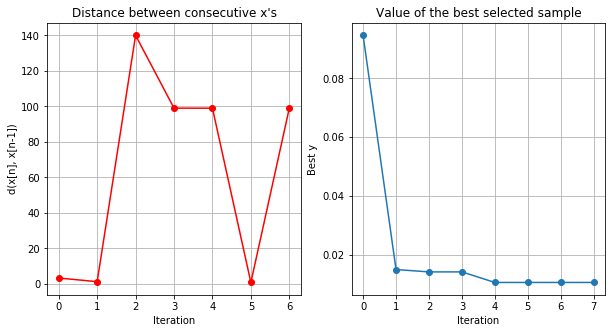

In [171]:
# Initinalize optimizer
opt_xgb = GPyOpt.methods.BayesianOptimization(
    f = obj_xgb, 
    domain = bounds_xgb,
    acquisition_type = 'MPI')

# Set max iterations and time
max_iter = 50
max_time = 60

# Perform optimization
opt_xgb.run_optimization(max_iter, max_time)

opt_xgb.plot_convergence()

In [172]:
# Record minimum MSE
results.loc['xgb', 'avg_mse'] = np.min(opt_xgb.Y) 

# Recrord the 'gain'
results.loc['xgb', 'gain'] = 100 * results.loc['xgb', 'baseline']/np.min(opt_xgb.Y)

# Save optimal parameters
pars_xgb = opt_xgb.X[np.argmin(opt_xgb.Y)]

Let us fit an XGBoost model with the optimal hyperparameters and we will record the error between the predicted and true values of $y$.

In [173]:
# Instantiate model with hyperparameters
xgboost = xgb.XGBRegressor(learning_rate = pars_xgb[0],
                           gamma = pars_xgb[1], 
                           max_depth = int(pars_xgb[2]),
                           n_estimators = int(pars_xgb[3]))       
          
# Fit model
xgboost.fit(x, y_noisy)

# Predict values in training set
y_pred = xgboost.predict(x)

# Save results
results.loc['xgb', 'true_mse'] = get_mse(y_pred)


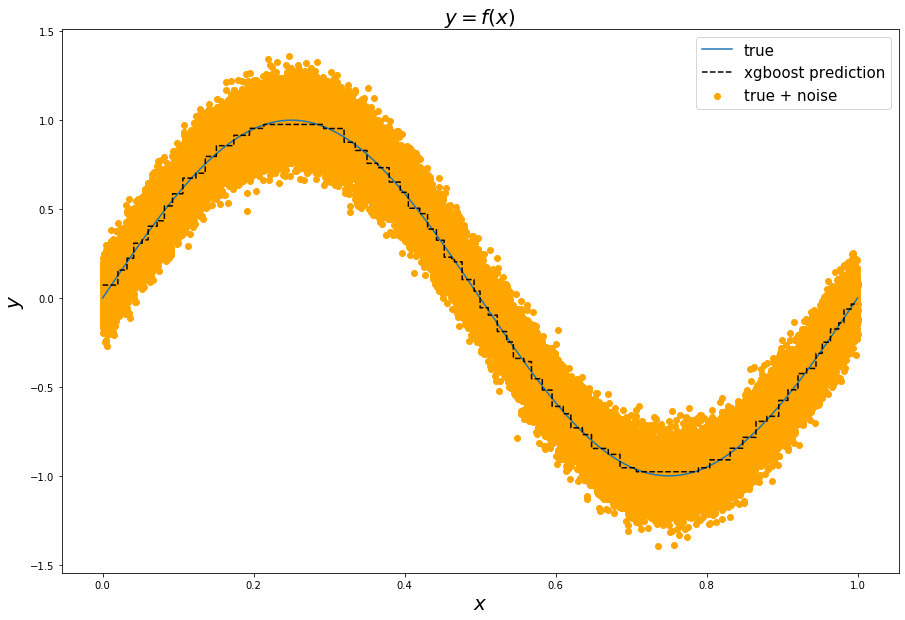

In [174]:
# Plot predicted values along with others 
fig, ax = plt.subplots(1, 1, figsize = (15, 10))

ax.set_title(r'$ y = f(x)$', fontsize = 20)
ax.set_xlabel(r'$x$', fontsize = 20)
ax.set_ylabel(r'$y$', fontsize = 20)

ax.plot(x, y, label = 'true')
ax.scatter(x_train, y_train, label = 'true + noise', color = 'orange')
ax.plot(x, y_pred, label = 'xgboost prediction', linestyle = 'dashed', color = 'black')
ax.legend(fontsize = 15)

plt.show()

The following code chunk optimizers the hyperparameters for the neural network model.

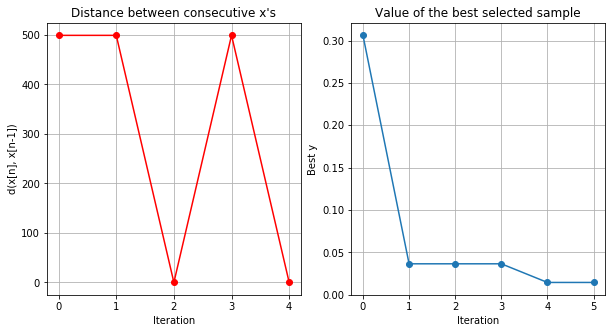

In [175]:
# Inintialize optimization
opt_nn = GPyOpt.methods.BayesianOptimization(
    f = obj_nn, 
    domain = bounds_nn,
    acquisition_type = 'MPI')

# Set max interations and max time
max_iter = 50
max_time = 60

# Perform optimization
opt_nn.run_optimization(max_iter, max_time)

opt_nn.plot_convergence()

In [176]:
# Record minimum MSE
results.loc['nn', 'avg_mse'] = np.min(opt_nn.Y)

# Record 'gain' over baseline
results.loc['nn', 'gain'] = 100 * results.loc['nn', 'baseline']/np.min(opt_nn.Y)

# Record optimal parameters
pars_nn = opt_nn.X[np.argmin(opt_nn.Y)]

Let us fit a model with these hyperparameters and we will record the error between our predictions and the true values.

In [177]:
# Instantiate model with hyperparameters
net = nn.MLPRegressor(alpha = pars_nn[0], hidden_layer_sizes = int(pars_nn[1]))       
          
# Fit model
net.fit(x, y_noisy)

# Predict values in training set
y_pred = net.predict(x)

# Record error between predictions and true value
results.loc['nn', 'true_mse'] = get_mse(y_pred)

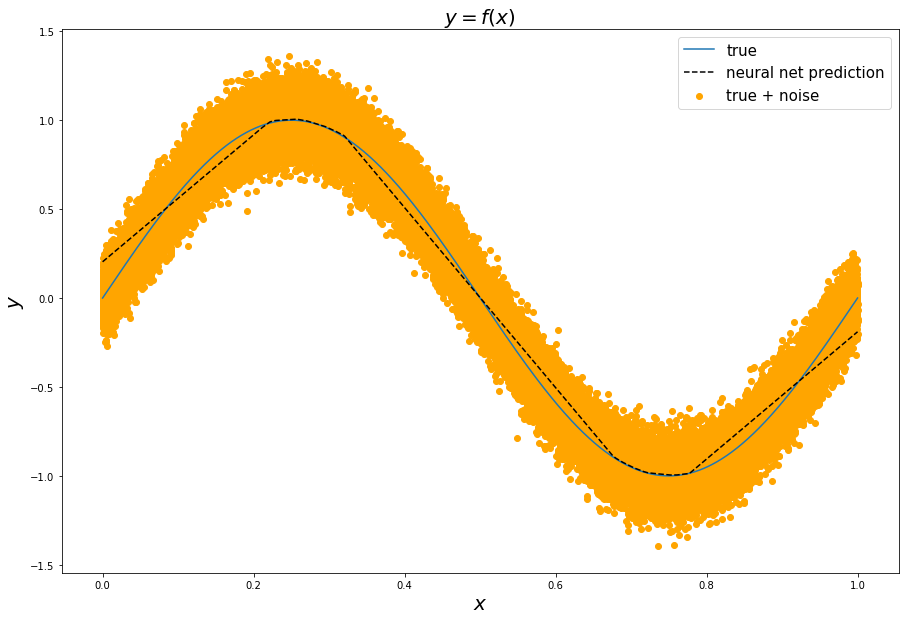

In [178]:
# Plot predicted values along with others 
fig, ax = plt.subplots(1, 1, figsize = (15, 10))

ax.set_title(r'$ y = f(x)$', fontsize = 20)
ax.set_xlabel(r'$x$', fontsize = 20)
ax.set_ylabel(r'$y$', fontsize = 20)

ax.plot(x, y, label = 'true')
ax.scatter(x_train, y_train, label = 'true + noise', color = 'orange')
ax.plot(x, y_pred, label = 'neural net prediction', linestyle = 'dashed', color = 'black')
ax.legend(fontsize = 15)

plt.show()

The XGBoost model did quite a bit better at predicting the true values. Both models saw substantial improvement as a result of the parameter tuning.

In [179]:
# Print results
results

,baseline,avg_mse,gain,true_mse
xgb,0.010104,0.010698,94.449651,0.000502
nn,0.010122,0.014414,70.226015,0.004016


In [180]:
# Recrod the final amount of time for the process
duration = time.time() - start_time

print('The program took {} minutes on our 8GB of RAM MacBook Air.'.format(round(duration/60, 2)))

The program took 23.39 minutes on our 8GB of RAM MacBook Air.


# Conclusion
Bayesian optimization produced substantial improvement over the default hyperparameters. This was obtained within a reasonable amount of time. Hence, the objective of this exercise was fulfilled.